# Assignment: Naive Bayes

## Part 1: Base code

Instructions
1. Do **not** shuffle the data set
2. Treat the features as nominal and use them as provided (e.g., do **not** convert them to other feature types, such as numeric ones). Implement a Naive Bayes classifier with appropriate likelihood function for the data.
3. You should implement the Naive Bayes classifier from scratch. Do **not** use existing implementations/learning algorithms. You must use epsilon smoothing strategy as discussed in the Naive Bayes lecture. 
4. Apart from the instructions in point 3, you may use libraries to help you with data reading, representation, maths or evaluation.


In [6]:
# This function should open a csv file and read the data into a useable format [0.5 mark]
def preprocess(filename):
    
    features = []
    labels = []
    
    with open(filename, mode='r') as data:
        for line in data:
            inst = line.strip().split(",")
            features.append(inst[1:-1]) #exclude ID(first column) and label(last column)
            labels.append(inst[-1])
        
        feature_head = features[0]
        del features[0]
        del labels[0]
        
    return feature_head, features, labels


In [7]:
import pandas as pd

# This function should build a supervised NB model [3 marks]
def train(feature_head, features, labels):
    
############## CALCULATE PRIOR PROBABLITIES ##############

    prior_count = {} #Dictionary to contain each label and their corresponding count
    N = 0 #To track total number of instances
    
    for y in labels:
        N +=1
        if y in prior_count:
            prior_count.update({y : prior_count.get(y) + 1})
        else:
            prior_count[y] = 1

    prior_prob = {} #Dictionary to contain each label and their corresponding prior probablity
    for label_values in prior_count:
        prior_prob.update({label_values : prior_count[label_values] / N})

############## CALCULATE LIKELIHOOD PROBABLITIES ##############
    
    #Convert features to dataframe
    df_features = pd.DataFrame(features, columns = feature_head)
    
    #Create outline of nested dictionary to contain feature type, label,
    #feature value and corresponding count
    likelihood_count = {}
    for attr in df_features:
        likelihood_count[attr] = {}
        for label in prior_prob:
            likelihood_count[attr][label]={}
            for value in df_features[attr].unique():
                likelihood_count[attr][label][value] = 0 #Update from 0 to 1 to apply Laplace smoothing

    #Count and update values in nested dictionary
    for col in range(0, len(features[0])):     
        for row in range (0, len(features)):
            
            if feature_head[col] in likelihood_count:
                if labels[row] in likelihood_count[feature_head[col]]:
                    if features[row][col] in likelihood_count[feature_head[col]][labels[row]]:
                        
                        count = likelihood_count.get(feature_head[col]).get(labels[row]).get(features[row][col])
                        likelihood_count[feature_head[col]][labels[row]][features[row][col]]  = count + 1
    
    #Create outline of nested dictionary to contain feature type, label,
    #feature value and corresponding likelihood probabilities
    likelihood_prob = {}
    for attr in likelihood_count:
        likelihood_prob[attr] = {}
        for label in likelihood_count[attr]:
            likelihood_prob[attr][label] = {}
            label_count = 0
            
            #Count denominator
            for value in likelihood_count[attr][label]:
                label_count += likelihood_count[attr][label][value]
            
            #Calculate and update probability value
            for value in likelihood_count[attr][label]:
                
                if likelihood_count[attr][label][value] != 0:
                    likelihood_prob[attr][label][value] = likelihood_count[attr][label][value] / label_count
                else:
                    epsilon = pow(10,-6) * 1/N #guaranteed smaller than 1/N
                    likelihood_prob[attr][label][value] = epsilon

    return prior_prob, likelihood_prob


In [8]:
import math
# This function should predict the class for a set of instances, based on a trained model [1.5 marks]
def predict(features, feature_head, prior_prob, likelihood_prob):
    
    label_predict_data = {}
    label_predict = []
    label_predict_prob = []

    for instance in features:
        
        #Add log value of prior probability to label_predict_data
        for label in prior_prob:
            label_predict_data[label] = math.log(prior_prob[label])
                
            for attr in feature_head:
                attr_num = feature_head.index(attr)
                
                #Add log value of likelihood probability to label_predict_data
                if instance[attr_num] in likelihood_prob[attr][label]:
                    label_predict_data[label] += math.log(likelihood_prob[attr][label][instance[attr_num]])
            
            #Track each label and their corresponding log summation probability value
            label_predict_prob.append(label + " : " + str(label_predict_data[label]))
        
        #Save label name with the higher log probability value for each instance
        label_predict.append(max(label_predict_data, key=label_predict_data.get))
        
    #Rearrange formatting of the label and their corresponding log summation probability value for each instance
    num_labels = len(prior_prob)
    for i in range(len(label_predict_prob)):
        start = i
        end = i+num_labels
        label_predict_prob[start:end] = [', '.join(label_predict_prob[start:end])]
    
    return label_predict, label_predict_prob


In [9]:
# This function should evaluate a set of predictions [1 mark]
def evaluate(predicted_labels, labels, interesting=None, print_stat=True):
    
    """
    interesting (optional) is to choose which label should be the interesting class
    for a binary class evaluation. If not given label with highest count in labels will be chosen.
    
    print_stat (optional) is to choose if a comprehensive set of metrics should be printed. It
    will be printed by default.
    
    returns accuracy value
    
    """

############################ HELPER FUNCTIONS ############################
    
    #Helper function to count tp, tn, fn, fp for a given class
    def calc(predicted_labels, labels, interesting):
        tp = tn = fn = fp = 0

        for i in range(len(labels)):
                
            if labels[i] == interesting:
                
                if predicted_labels[i] == interesting:
                    tp += 1
                
                elif predicted_labels[i] != interesting:
                    fn += 1
            
            elif labels[i] != interesting:
                
                if predicted_labels[i] == interesting:
                    fp += 1
                    
                elif predicted_labels[i] != interesting:
                    tn += 1

        return tp, tn, fn, fp

    #Helper functions to calculate different evaluation metrics
    def accuracy(tp, tn, fn, fp):
        return ((tp + tn) / (tp + tn + fn + fp))
    def precision(tp, fp):
        if tp + fp == 0:
            precision = 1
        else:
            precision = (tp / (tp + fp))
        return precision
    def recall(tp, fn):
        if tp + fn == 0:
            recall = 1
        else:
            recall = (tp / (tp + fn))
        return recall
    def f1_score(precision, recall):
        if precision + recall == 0:
            f_score = 0
        else:
            f_score = (2 * precision * recall) / (precision + recall)
        return f_score
    
####################################################################################

    #Unique value of labels
    label_values_unique = []
    for value in labels:
        if value not in label_values_unique:
            label_values_unique.append(value)

############################ BINARY CLASS EVALUATION ############################

    if len(label_values_unique) == 2:
        
        #Define interesting class by selecting the class in training data with highest count
        if interesting==None:
            interesting = max(labels, key = labels.count)
        tp, tn, fn, fp = calc(predicted_labels, labels, interesting)
        
        accuracy = accuracy(tp, tn, fn, fp)
        precision = precision(tp, fp)
        recall = recall(tp, fn)
        f1_score = f1_score(precision, recall)
        
        if print_stat==True:
            print("\033[1m" + "Binary class evaluation" + "\033[0m" + " (interesting class: "
                  + interesting + ")")
            print("Accuracy: " + format(accuracy, '%'))
            print("Error rate: " + format(1-accuracy, '%'))
            print("\nPrecision: " + format(precision, '%'))
            print("Recall: " + format(recall, '%'))
            print("F1-score: " + format(f1_score, '%'))
            
############################ MULTI-CLASS EVALUATION ############################
    
    elif len(label_values_unique) > 2:
        
        precision_sum = 0 #macro-average precision numerator
        recall_sum = 0 #macro-average recall numerator
        f1_score_sum = 0 #macro-average f1 score numerator
        
        #micro-average related
        total_tp = 0
        total_tn = 0
        total_fp = 0
        total_fn = 0
        class_num = len(label_values_unique)

        #weighted average related
        precision_wgt_avg = 0
        recall_wgt_avg = 0
        f1_score_wgt_avg = 0
        f1_score_avg = 0
        inst_num = len(labels)

        for y in label_values_unique:
            
            interesting = y
            tp, tn, fn, fp = calc(predicted_labels, labels, interesting)
            
            current_precision = precision(tp, fp)
            current_recall = recall(tp, fn)
            
            precision_sum += current_precision #macro-average precision numerator
            recall_sum += current_recall #macro-average recall numerator
            f1_score_sum += f1_score(current_precision, current_recall) #macro-average f1 score numerator
            
            total_tp += tp
            total_tn += tn
            total_fn += fn
            total_fp += fp
            
            precision_wgt_avg += ((current_precision * (tp+fn) / inst_num))
            recall_wgt_avg += ((current_recall * (tp+fn) / inst_num))
            f1_score_wgt_avg += (f1_score(current_precision, current_recall)* (tp+fn) / inst_num)

        accuracy = accuracy(total_tp, 0, total_fn, 0)

        precision_mac_avg = precision_sum / class_num
        recall_mac_avg = recall_sum / class_num
        f1_score_mac_avg = f1_score_sum / class_num

        precision_mic_avg = precision(total_tp, total_fp)
        recall_mic_avg = recall(total_tp, total_fn)
        f1_score_mic_avg = f1_score(precision_mic_avg, recall_mic_avg)

        if print_stat==True:
            print("\033[1m" + "Multi-class evaluation" + "\033[0m")
            print("Accuracy: " + format(accuracy, '%'))
            print("Error rate: " + format(1-accuracy, '%'))

            print("\033[4m" + "\nMacro-average metrics" + "\033[0m")
            print("Precision: " + format(precision_mac_avg, '%'))
            print("Recall: " + format(recall_mac_avg, '%'))
            print("F1-score: " + format(f1_score_mac_avg, '%'))

            print("\033[4m" + "\nMicro-average metrics" + "\033[0m")
            print("Precision: " + format(precision_mic_avg, '%'))
            print("Recall: " + format(recall_mic_avg, '%'))
            print("F1-score: " + format(f1_score_mic_avg, '%'))

            print("\033[4m" + "\nWeighted-average metrics" + "\033[0m")
            print("Precision: " + format(precision_wgt_avg, '%'))
            print("Recall: " + format(recall_wgt_avg, '%'))
            print("F1-score: " + format(f1_score_wgt_avg, '%'))

    return accuracy


## Bank Marketing

In [10]:
# This cell should act as your "main" function where you call the above functions 
# on the full Bank Marketing data set, and print the evaluation score. [0.33 marks]


# First, read in the data and apply your NB model to the Bank Marketing data

feature_head, features, labels = preprocess("dataset/bank-marketing.csv")
prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)

# Second, print the full evaluation results from the evaluate() function

evaluate(predicted_labels, labels, 'yes')
print("_" * 110 + "\n")

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized


print("Feature vectors of instances [0, 1, 2]: ", features[0:3])

print("\nNumber of instances (N): ", len(features))
print("Number of features (F): ", len(features[0]))
print("Number of labels (L): ", len(prior_prob))

print("\n\nPredicted class probabilities for instance N-3: ", predicted_labels_prob[len(features)-3])
print("Predicted class for instance N-3: ", predicted_labels[len(features)-3])
print("\nPredicted class probabilities for instance N-2: ", predicted_labels_prob[len(features)-2])
print("Predicted class for instance N-2: ", predicted_labels[len(features)-2])
print("\nPredicted class probabilities for instance N-1: ", predicted_labels_prob[len(features)-1])
print("Predicted class for instance N-1: ", predicted_labels[len(features)-1])


Binary class evaluation (interesting class: yes)
Accuracy: 88.741429%
Error rate: 11.258571%

Precision: 52.500000%
Recall: 24.184261%
F1-score: 33.114323%
______________________________________________________________________________________________________________

Feature vectors of instances [0, 1, 2]:  [['unemployed', 'married', 'primary', 'no', 'no', 'no', 'cellular', 'oct', 'unknown'], ['services', 'married', 'secondary', 'no', 'yes', 'yes', 'cellular', 'may', 'failure'], ['management', 'single', 'tertiary', 'no', 'yes', 'no', 'cellular', 'apr', 'failure']]

Number of instances (N):  4521
Number of features (F):  9
Number of labels (L):  2


Predicted class probabilities for instance N-3:  no : -6.711607763537066, yes : -8.58311083143239
Predicted class for instance N-3:  no

Predicted class probabilities for instance N-2:  no : -10.619918711707392, yes : -11.68220339799834
Predicted class for instance N-2:  no

Predicted class probabilities for instance N-1:  no : -14.887013805

## Student

In [11]:
# This cell should act as your "main" function where you call the above functions 
# on the full Student data set, and print the evaluation score. [0.33 marks]


# First, read in the data and apply your NB model to the Student data

feature_head, features, labels = preprocess("dataset/student.csv")
prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)

# Second, print the full evaluation results from the evaluate() function

evaluate(predicted_labels, labels)
print("_" * 110 + "\n")

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized


print("Feature vectors of instances [0, 1, 2]: ", features[0:3])

print("\nNumber of instances (N): ", len(features))
print("Number of features (F): ", len(features[0]))
print("Number of labels (L): ", len(prior_prob))

print("\n\nPredicted class probabilities for instance N-3: ", predicted_labels_prob[len(features)-3])
print("Predicted class for instance N-3: ", predicted_labels[len(features)-3])
print("\nPredicted class probabilities for instance N-2: ", predicted_labels_prob[len(features)-2])
print("Predicted class for instance N-2: ", predicted_labels[len(features)-2])
print("\nPredicted class probabilities for instance N-1: ", predicted_labels_prob[len(features)-1])
print("Predicted class for instance N-1: ", predicted_labels[len(features)-1])


Multi-class evaluation
Accuracy: 48.382126%
Error rate: 51.617874%

Macro-average metrics
Precision: 48.358501%
Recall: 47.636445%
F1-score: 47.849115%

Micro-average metrics
Precision: 48.382126%
Recall: 48.382126%
F1-score: 48.382126%

Weighted-average metrics
Precision: 48.577421%
Recall: 48.382126%
F1-score: 48.349640%
______________________________________________________________________________________________________________

Feature vectors of instances [0, 1, 2]:  [['GP', 'F', 'U', 'GT3', 'A', 'high', 'high', 'at_home', 'teacher', 'course', 'mother', 'medium', 'medium', 'none', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'good', 'mediocre', 'good', 'very_bad', 'very_bad', 'mediocre', 'four_to_six'], ['GP', 'F', 'U', 'GT3', 'T', 'low', 'low', 'at_home', 'other', 'course', 'father', 'low', 'medium', 'none', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'excellent', 'mediocre', 'mediocre', 'very_bad', 'very_bad', 'mediocre', 'one_to_three'], ['GP', 'F', 'U', 'LE3', 'T

## Obesity

In [12]:
# This cell should act as your "main" function where you call the above functions 
# on the full Obesity data set, and print the evaluation score. [0.33 marks]


# First, read in the data and apply your NB model to the Obesity data

feature_head, features, labels = preprocess("dataset/obesity.csv")
prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)

# Second, print the full evaluation results from the evaluate() function

evaluate(predicted_labels, labels, 'obese')
print("_" * 110 + "\n")

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized


print("Feature vectors of instances [0, 1, 2]: ", features[0:3])

print("\nNumber of instances (N): ", len(features))
print("Number of features (F): ", len(features[0]))
print("Number of labels (L): ", len(prior_prob))

print("\n\nPredicted class probabilities for instance N-3: ", predicted_labels_prob[len(features)-3])
print("Predicted class for instance N-3: ", predicted_labels[len(features)-3])
print("\nPredicted class probabilities for instance N-2: ", predicted_labels_prob[len(features)-2])
print("Predicted class for instance N-2: ", predicted_labels[len(features)-2])
print("\nPredicted class probabilities for instance N-1: ", predicted_labels_prob[len(features)-1])
print("Predicted class for instance N-1: ", predicted_labels[len(features)-1])


Binary class evaluation (interesting class: obese)
Accuracy: 77.830412%
Error rate: 22.169588%

Precision: 71.000000%
Recall: 87.654321%
F1-score: 78.453039%
______________________________________________________________________________________________________________

Feature vectors of instances [0, 1, 2]:  [['Male', 'yes', 'yes', 'mid', 'high', 'Sometimes', 'yes', 'mid', 'no', 'low-activity', 'mediocre', 'Frequently', 'Public_Transportation'], ['Male', 'yes', 'yes', 'mid', 'high', 'Sometimes', 'no', 'high', 'no', 'low-activity', 'good', 'Sometimes', 'Public_Transportation'], ['Male', 'yes', 'yes', 'high', 'high', 'Sometimes', 'no', 'high', 'no', 'low-activity', 'good', 'Sometimes', 'Public_Transportation']]

Number of instances (N):  2111
Number of features (F):  13
Number of labels (L):  2


Predicted class probabilities for instance N-3:  not-obese : -11.010971850189438, obese : -16.78139621234939
Predicted class for instance N-3:  not-obese

Predicted class probabilities for inst

#### Part 2: Conceptual analysis

## Question: One-R Baseline

In [13]:
# Write additional code here, if necessary (you may insert additional code cells)
# You should implement the One-R classifier from scratch. Do not use existing implementations/learning algorithms.
# Print the feature name and its corresponding error rate that One-R selects, in addition to any evaluation scores.

def one_r(feature_head, features, labels):

    #Unique value of labels
    label_values_unique = []
    for value in labels:
        if value not in label_values_unique:
            label_values_unique.append(value)
    
    #Convert features to dataframe
    df_features = pd.DataFrame(features, columns = feature_head)
    
    #Create outline of nested dictionary to contain feature type, label,
    #feature value and corresponding count
    likelihood_count = {}
    for attr in df_features:
        likelihood_count[attr] = {}
        for value in df_features[attr].unique():
            likelihood_count[attr][value] = {}
            for label in label_values_unique:
                likelihood_count[attr][value][label]= 0
            
    #Count and update values in nested dictionary
    for col in range(0, len(features[0])):     
        for row in range (0, len(features)):
            
            if feature_head[col] in likelihood_count:
                if features[row][col] in likelihood_count[feature_head[col]]:
                    if labels[row] in likelihood_count[feature_head[col]][features[row][col]]:
                    
                        count = likelihood_count.get(feature_head[col]).get(features[row][col]).get(labels[row])
                        likelihood_count[feature_head[col]][features[row][col]][labels[row]]  = count + 1
            
############################ CALCULATE ERROR FOR FEATURES ############################
    
    feature_error = {}
    
    for attr in likelihood_count:
        
        error_num = 0
        error_dem = 0
        for value in likelihood_count[attr]:
            
            max_count_label = 0
            total_count_label = 0
            for label in likelihood_count[attr][value]:
                if likelihood_count[attr][value].get(label) > max_count_label:
                    max_count_label = likelihood_count[attr][value].get(label)
                
            for label in likelihood_count[attr][value]:
                total_count_label += likelihood_count[attr][value].get(label)
            
            error_num += total_count_label - max_count_label
            error_dem += total_count_label
            
        feature_error[attr] = error_num/error_dem

    lowest_error = min(feature_error, key=feature_error.get)
    print("Feature: ",lowest_error, "\nError rate: ", format(feature_error[lowest_error],'%'))


In [14]:
feature_head, features, labels = preprocess("dataset/student.csv")
print("Dataset: Student")
one_r(feature_head, features, labels)

Dataset: Student
Feature:  Fedu 
Error rate:  66.563945%


In [15]:
feature_head, features, labels = preprocess("dataset/bank-marketing.csv")
print("Dataset: Bank Marketing")
one_r(feature_head, features, labels)

Dataset: Bank Marketing
Feature:  poutcome 
Error rate:  10.705596%


In [16]:
feature_head, features, labels = preprocess("dataset/obesity.csv")
print("Dataset: Obesity")
one_r(feature_head, features, labels)

Dataset: Obesity
Feature:  family_history_with_overweight 
Error rate:  36.475604%


## Question: Evaluation strategy


In [17]:
import numpy
# Write additional code here, if necessary (you may insert additional code cells)

def cross_val(feature_head, features, labels, k=10):
    
    #default k value is 10 unless otherwise specified
    
    if k < 2:
        return print("Error: Unable to perform cross validation with k=" + str(k)
                     +". k must be >= 2.")
    
    if k > len(features):
        return ("Error: Unable to perform cross validation with k=" + str(k)
                     +". k must be <=" + str(len(features)) + ".")
    
    k = int(k)
    bucket = [0]*k
    inst_total = 0
    loop = True

    #Create buckets and determine number of elements per bucket (folds)
    while loop == True:
        for i in range(k):
            bucket[i] += 1
            inst_total += 1
            if inst_total == len(features):
                loop = False
                break
    
    #Determine cumulative number of elements per kth bucket
    bucket_cum = [0]
    ith_total = 0
    
    for i in range(k):
        ith_total += bucket[i]
        bucket_cum.append(ith_total)
    
    #Do evaluation per k fold
    kth_fold = 0
    accuracy_sum = 0
    accuracy_data = []
    
    #Uncomment (1/3) for alternative averaging method
    #all_predicted_labels = []
    
    for i in range(k):
        
        kth_fold += 1
        
        #Split test and train features per kth fold
        test_features = features[bucket_cum[i]: bucket_cum[i+1]]
        train_features = features[0:bucket_cum[i]] + features[bucket_cum[i+1]:bucket_cum[k]]
        test_labels = labels[bucket_cum[i]: bucket_cum[i+1]]
        train_labels = labels[0:bucket_cum[i]] + labels[bucket_cum[i+1]:bucket_cum[k]]   
        
        #Train and predict labels
        prior_prob, likelihood_prob = train(feature_head, train_features, train_labels)
        predicted_labels, predicted_labels_prob = predict(test_features, feature_head, prior_prob, likelihood_prob)
        
        #Uncomment (2/3) for alternative averaging method
        #all_predicted_labels += predicted_labels
                
        accuracy = evaluate(predicted_labels, test_labels, print_stat=False)
        accuracy_sum += accuracy
        accuracy_data.append(accuracy)
        
        #Accuracy per k fold
        print("Accuracy for " + str(kth_fold) + "th fold is " + format(accuracy, '%'))
    
    #Average accuracy accross all k folds
    print("Average accuracy is " + format(accuracy_sum/k, '%'))
    print("Standard deviation of accuracy is " + str(numpy.std(accuracy_data)))

    #Uncomment (3/3) for alternative averaging method
    #print(format(evaluate(all_predicted_labels, labels, print_stat=False), '%'))


In [18]:
feature_head, features, labels = preprocess("dataset/bank-marketing.csv")
prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)
accuracy = evaluate(predicted_labels, labels, print_stat=False)
print("bank marketing without cross_val")
print("Accuracy is " + format(accuracy, '%'))

print("\ncross_val for bank marketing with k=2")
cross_val(feature_head, features, labels, 2)

print("\ncross_val for bank marketing with k=10")
cross_val(feature_head, features, labels)

print("\ncross_val for bank marketing with k=50")
cross_val(feature_head, features, labels, 50)


bank marketing without cross_val
Accuracy is 88.741429%

cross_val for bank marketing with k=2
Accuracy for 1th fold is 87.925697%
Accuracy for 2th fold is 89.380531%
Average accuracy is 88.653114%
Standard deviation of accuracy is 0.007274171895120363

cross_val for bank marketing with k=10
Accuracy for 1th fold is 87.858720%
Accuracy for 2th fold is 88.274336%
Accuracy for 3th fold is 88.053097%
Accuracy for 4th fold is 88.495575%
Accuracy for 5th fold is 87.389381%
Accuracy for 6th fold is 91.371681%
Accuracy for 7th fold is 87.831858%
Accuracy for 8th fold is 90.707965%
Accuracy for 9th fold is 88.495575%
Accuracy for 10th fold is 87.831858%
Average accuracy is 88.631005%
Standard deviation of accuracy is 0.01254522507892106

cross_val for bank marketing with k=50
Accuracy for 1th fold is 85.714286%
Accuracy for 2th fold is 89.010989%
Accuracy for 3th fold is 91.208791%
Accuracy for 4th fold is 85.714286%
Accuracy for 5th fold is 86.813187%
Accuracy for 6th fold is 89.010989%
Accur

In [19]:
feature_head, features, labels = preprocess("dataset/student.csv")
prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)
accuracy = evaluate(predicted_labels, labels, print_stat=False)
print("student without cross_val")
print("Accuracy is " + format(accuracy, '%'))

print("\ncross_val for student with k=2")
cross_val(feature_head, features, labels, 2)

print("\ncross_val for student with k=10")
cross_val(feature_head, features, labels)

print("\ncross_val for student with k=50")
cross_val(feature_head, features, labels, 50)

student without cross_val
Accuracy is 48.382126%

cross_val for student with k=2
Accuracy for 1th fold is 31.692308%
Accuracy for 2th fold is 30.246914%
Average accuracy is 30.969611%
Standard deviation of accuracy is 0.007226970560303886

cross_val for student with k=10
Accuracy for 1th fold is 36.923077%
Accuracy for 2th fold is 24.615385%
Accuracy for 3th fold is 53.846154%
Accuracy for 4th fold is 27.692308%
Accuracy for 5th fold is 47.692308%
Accuracy for 6th fold is 29.230769%
Accuracy for 7th fold is 29.230769%
Accuracy for 8th fold is 36.923077%
Accuracy for 9th fold is 38.461538%
Accuracy for 10th fold is 32.812500%
Average accuracy is 35.742788%
Standard deviation of accuracy is 0.08733437740807407

cross_val for student with k=50
Accuracy for 1th fold is 23.076923%
Accuracy for 2th fold is 46.153846%
Accuracy for 3th fold is 53.846154%
Accuracy for 4th fold is 38.461538%
Accuracy for 5th fold is 30.769231%
Accuracy for 6th fold is 15.384615%
Accuracy for 7th fold is 38.46153

## Question: Feature Selection and Naive Bayes Assumptions

In [20]:
# Write additional code here, if necessary (you may insert additional code cells)

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def mutual_info(filename):
    feature_head, features, labels = preprocess(filename)
    df_features = pd.DataFrame(features, columns = feature_head)
    df_features = df_features.apply(LabelEncoder().fit_transform)
    
    mutual_info = mutual_info_classif(df_features, labels, discrete_features=True)

    mutual_info = pd.Series(mutual_info)
    mutual_info.index = df_features.columns
    sorted_mutual_info = mutual_info.sort_values(ascending=False)
    print(sorted_mutual_info)
    sorted_mutual_info.plot.bar(title='estimated mutual information vs features', color="#8BC6FC",
                                figsize=(15, 8), grid=True, ylabel='estimated mutual information',
                                xlabel='features', rot=45)


family_history_with_overweight    0.110464
CAEC                              0.081926
FAVC                              0.045862
NCP                               0.040228
SCC                               0.022762
FAF                               0.012892
MTRANS                            0.012838
CALC                              0.012794
FCVC                              0.012071
CH2O                              0.008715
TUE                               0.004173
SMOKE                             0.000067
Gender                            0.000001
dtype: float64


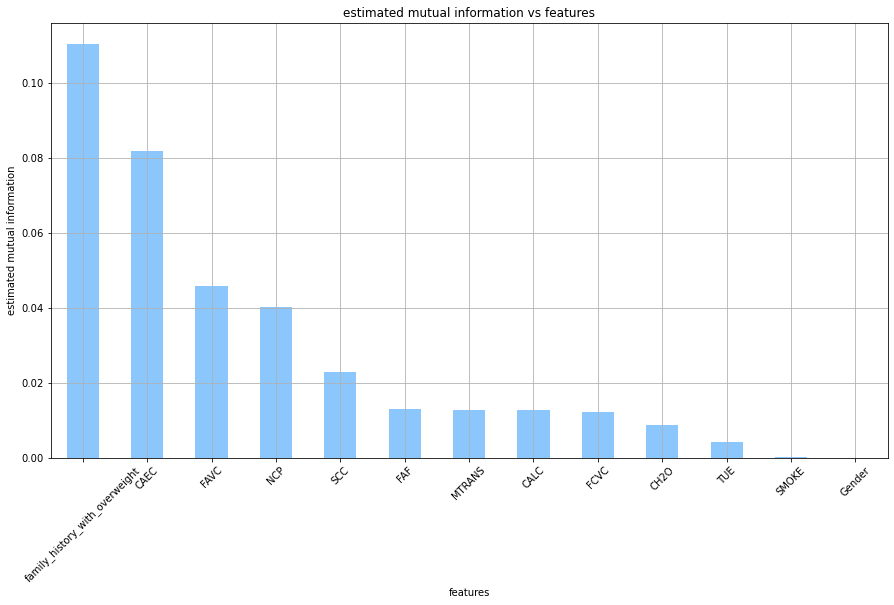

In [21]:
mutual_info("dataset/obesity.csv")

failures      0.115004
higher        0.070476
Medu          0.061935
school        0.056383
Mjob          0.047703
studytime     0.046910
Fedu          0.045311
goout         0.035669
Dalc          0.034225
Walc          0.031392
Fjob          0.030223
freetime      0.029560
reason        0.029396
absences      0.027289
health        0.026134
traveltime    0.025968
famrel        0.024792
schoolsup     0.019043
address       0.016689
internet      0.014743
guardian      0.013970
activities    0.009893
sex           0.009837
paid          0.008521
nursery       0.006334
romantic      0.004189
famsup        0.002193
famsize       0.002171
Pstatus       0.000957
dtype: float64


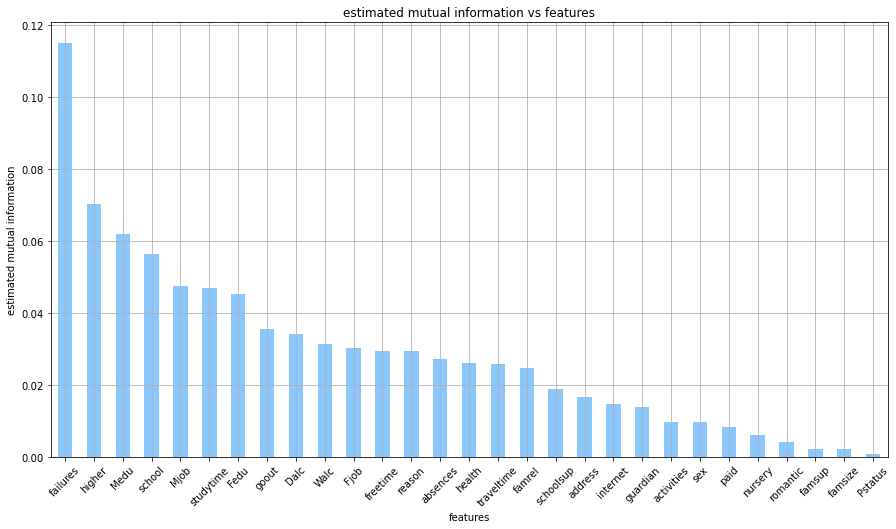

In [22]:
mutual_info("dataset/student.csv")

## Question: Feature Selection and Ethics

In [23]:
# Write additional code here, if necessary (you may insert additional code cells)

feature_head, features, labels = preprocess('dataset/student.csv')

#Ethically problematic features to remove (listed from left to right)
remove_attr = ['school', 'sex', 'address', 'famsize',
               'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
               'reason', 'guardian', 'traveltime', 'romantic', 'famrel']

#Corresponding index
remove_index = []
for attr in remove_attr:
    index = feature_head.index(attr)
    remove_index.append(index)

#Remove columns from right to left
for i in reversed(remove_index):
    [inst.pop(i) for inst in features]
    feature_head.pop(i)

prior_prob, likelihood_prob = train(feature_head, features, labels)
predicted_labels, predicted_labels_prob = predict(features, feature_head, prior_prob, likelihood_prob)
evaluate(predicted_labels, labels)
print("")

Multi-class evaluation
Accuracy: 44.684129%
Error rate: 55.315871%

Macro-average metrics
Precision: 44.302045%
Recall: 41.269090%
F1-score: 41.571040%

Micro-average metrics
Precision: 44.684129%
Recall: 44.684129%
F1-score: 44.684129%

Weighted-average metrics
Precision: 45.255584%
Recall: 44.684129%
F1-score: 44.130755%

